In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class Value:
    def __init__(self, data: float, _children: tuple = (), _op: str = "", label: str = ""): 
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self.label = label
        self._prev = set(_children)
        self._op = _op

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), _op="+")
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        
        return out
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)
    
    def __radd__(self, other):
        return self + other
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), _op="*")
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        
        return out
    
    def __rmul__(self, other):  # other * self
        return self * other
    
    def __truediv__(self, other):  # self / other
        out = self * other**-1
        return out
    
    def __pow__(self, other):
        if not isinstance(other, (int, float)):
            raise ValueError("Only supporting int/float for now")
        out = Value(self.data**other, (self, ), _op=f"**{other}")
        
        def _backward():
            self.grad += other * (self.data**(other-1)) * out.grad
        out._backward = _backward
        
        return out
        
    def exp(self):
        x = self.data
        out = Value(np.exp(x), (self, ), _op="exp")
        
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        
        return out
    
    def tanh(self):
        x = self.data
        out = Value((np.exp(2 * x) - 1) / (np.exp(2 * x) + 1), (self, ), _op="tanh")
        
        def _backward():
            self.grad += (1 - out.data**2) * out.grad
        out._backward = _backward
        
        return out
    
    def backward(self):
        topo = []
        visited = set()
        def build_topological_sort(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topological_sort(child)
                topo.append(v)
        build_topological_sort(self)
        
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

    def __repr__(self): 
        return f"Value(data={self.data})"

In [3]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
          # if this value is a result of some operation, create an op node for it
          dot.node(name = uid + n._op, label = n._op)
          # and connect this node to it
          dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

In [4]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()

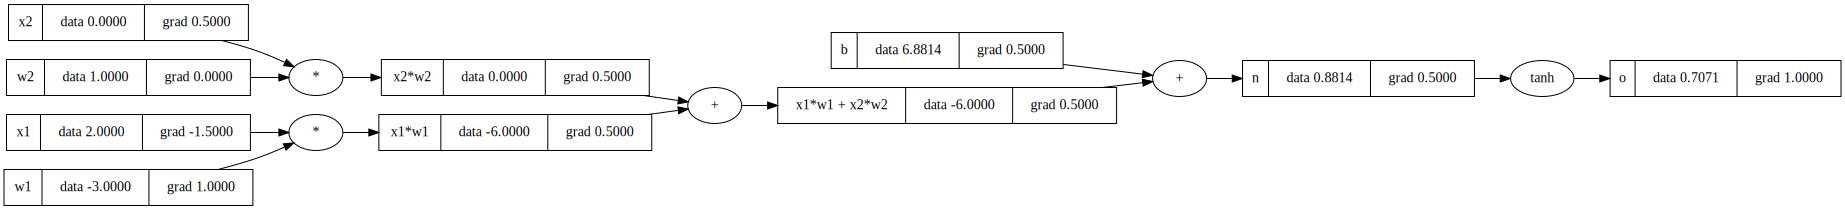

In [5]:
draw_dot(o)

In [6]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# ============
e = (2*n).exp()
o = (e - 1) / (e + 1); o.label = 'o'
# ============
o.backward()

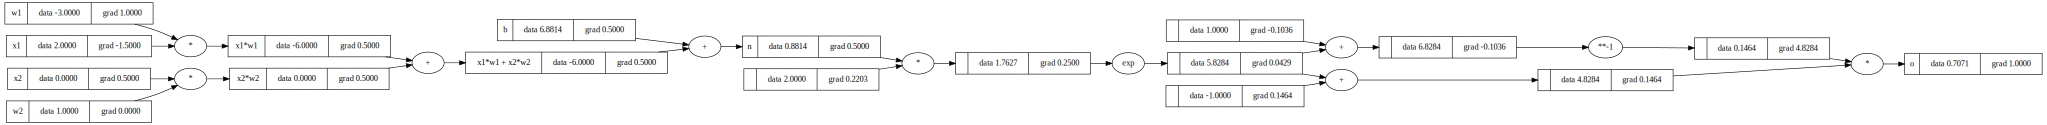

In [7]:
draw_dot(o)

### Let's switch to PyTorch

In [8]:
import torch 

x1 = torch.Tensor([2.0]).requires_grad_()
x2 = torch.Tensor([0.0]).requires_grad_()
w1 = torch.Tensor([-3.0]).requires_grad_()
w2 = torch.Tensor([1.0]).requires_grad_()
b = torch.Tensor([6.8813735870195432]).requires_grad_()

n = x1 * w1 + x2 * w2 + b
o = torch.tanh(n)

print(f"o: {o.data}")

o.backward()

print(f"x1: {x1.grad}")
print(f"w1: {w1.grad}")
print(f"x2: {x2.grad}")
print(f"w2: {w2.grad}")

o: tensor([0.7071])
x1: tensor([-1.5000])
w1: tensor([1.0000])
x2: tensor([0.5000])
w2: tensor([0.])


### Let's create a simple Neural Network using our Value object

In [9]:
import random 

class Neuron:
    def __init__(self, n_in):
        self.w = [Value(random.uniform(-1,1 )) for _ in range(n_in)]
        self.b = Value(random.uniform(-1, 1))
        
    def __call__(self, x):
        # w * x + b
        act = sum([wi * xi for wi, xi in zip(self.w, x)], self.b)
        out = act.tanh()
        return out
    
class Layer:
    def __init__(self, n_in, n_out):
        self.neurons = [Neuron(n_in) for _ in range(n_out)]
        
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
class MLP:
    def __init__(self, n_in, n_outs):
        sz = [n_in] + n_outs
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(n_outs))]
        
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

In [10]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=0.0878191421053561)

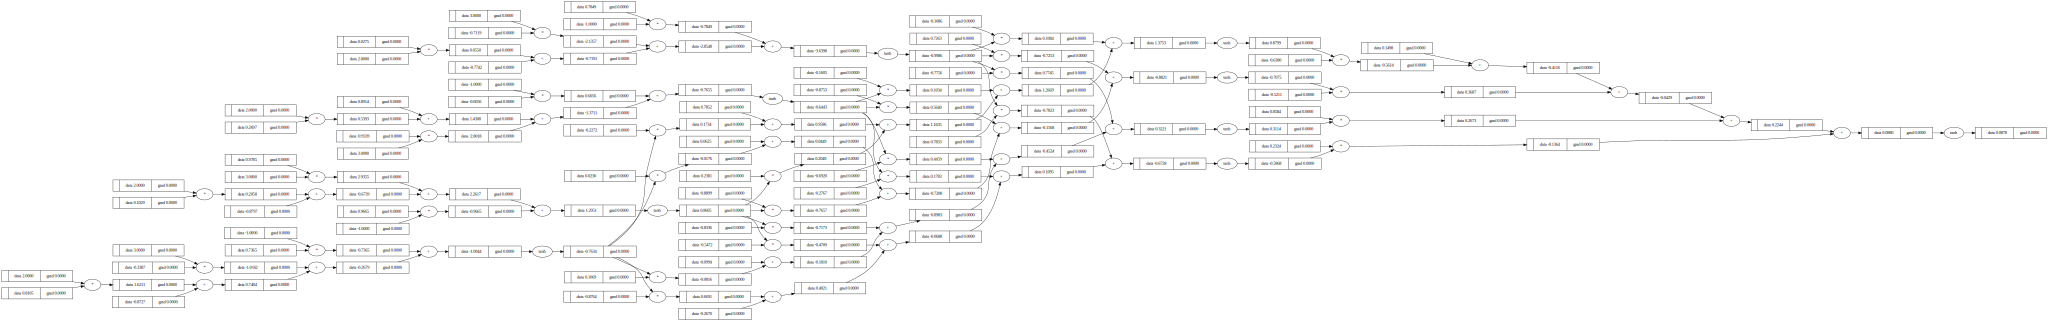

In [11]:
draw_dot(n(x))

In [12]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0]

In [13]:
y_preds = [n(x) for x in xs]
y_preds

[Value(data=0.0878191421053561),
 Value(data=-0.4376075018317519),
 Value(data=-0.2240582671870095),
 Value(data=0.44638099949113225)]

In [14]:
loss = sum((ypred - ytrue)**2 for ypred, ytrue in zip(y_preds, ys))
loss

Value(data=2.056938809950595)

In [15]:
loss.backward()

In [16]:
n.layers[0].neurons[0].w[0].grad

0.09762199578983213

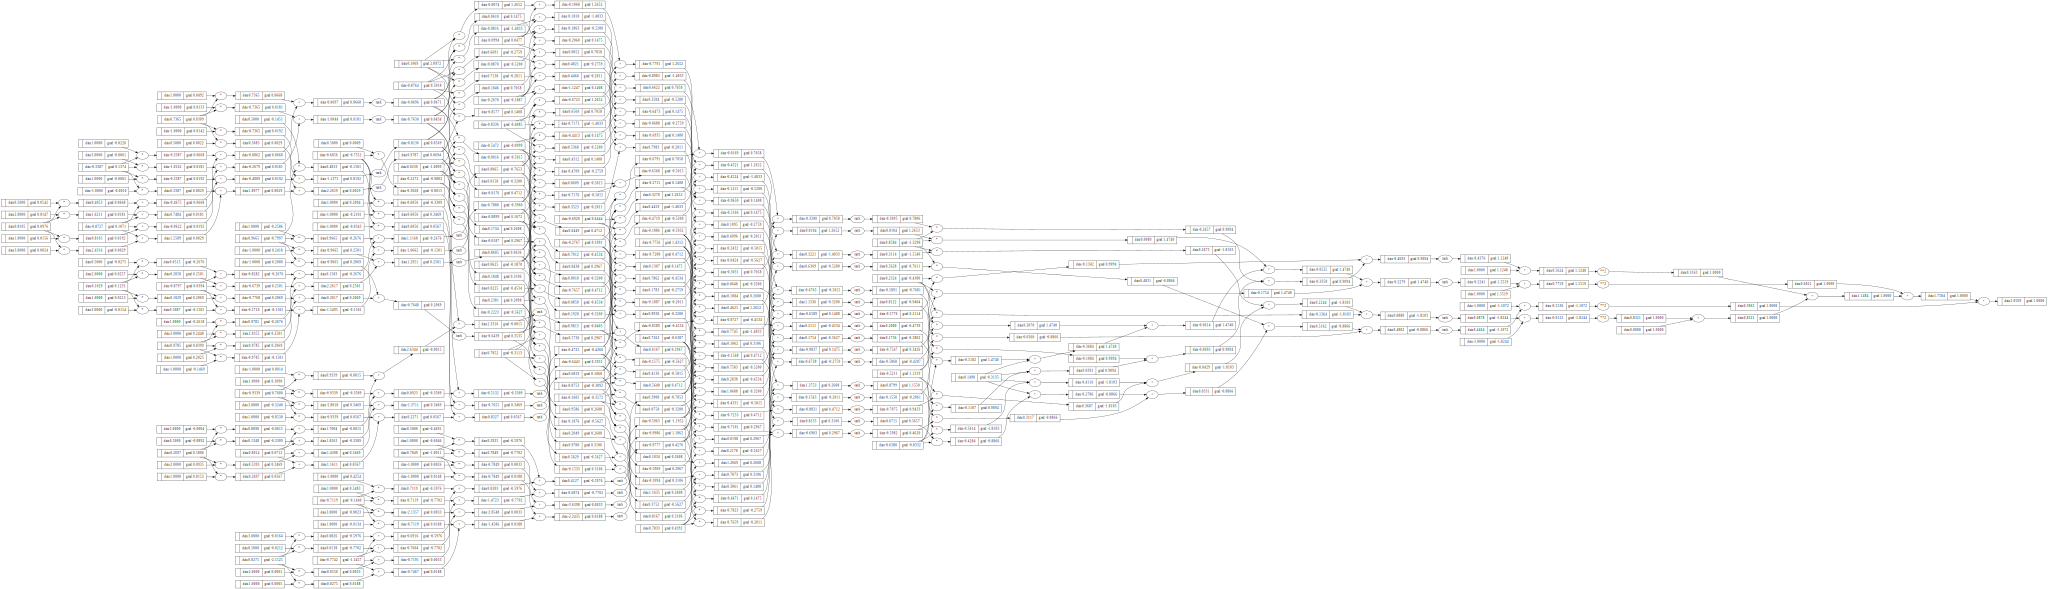

In [17]:
draw_dot(loss)